In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [3]:
df = pd.read_csv('D:/Belajar python/water_quality/waterQuality1.csv')
df.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [11]:
df['ammonia'] = pd.to_numeric(df['ammonia'], errors='coerce')

In [26]:
df.is_safe.value_counts()

0        7084
1         912
#NUM!       3
Name: is_safe, dtype: int64

In [33]:
df['is_safe']= pd.to_numeric(df['is_safe'], errors='coerce', downcast='signed')

In [34]:
df.isna().sum()

aluminium      0
ammonia        3
arsenic        0
barium         0
cadmium        0
chloramine     0
chromium       0
copper         0
flouride       0
bacteria       0
viruses        0
lead           0
nitrates       0
nitrites       0
mercury        0
perchlorate    0
radium         0
selenium       0
silver         0
uranium        0
is_safe        3
dtype: int64

In [37]:
df = df.dropna().reset_index(drop=True)

## EDA

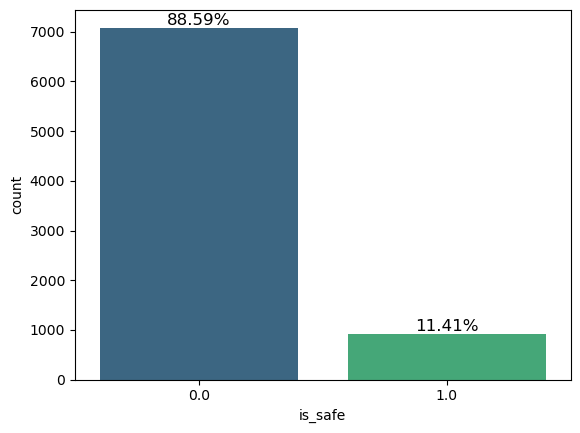

In [90]:
sns.countplot(data=df, x='is_safe', palette='viridis')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f%%' % (p.get_height()/len(df)*100),
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()

<Axes: >

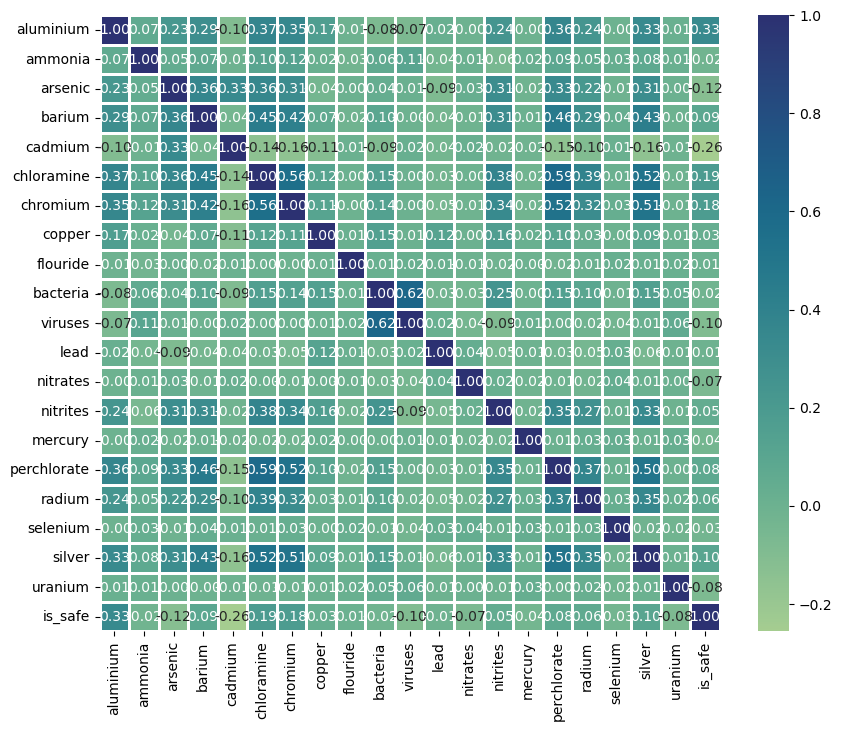

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='crest', annot=True, fmt='.2f', linewidths=1)

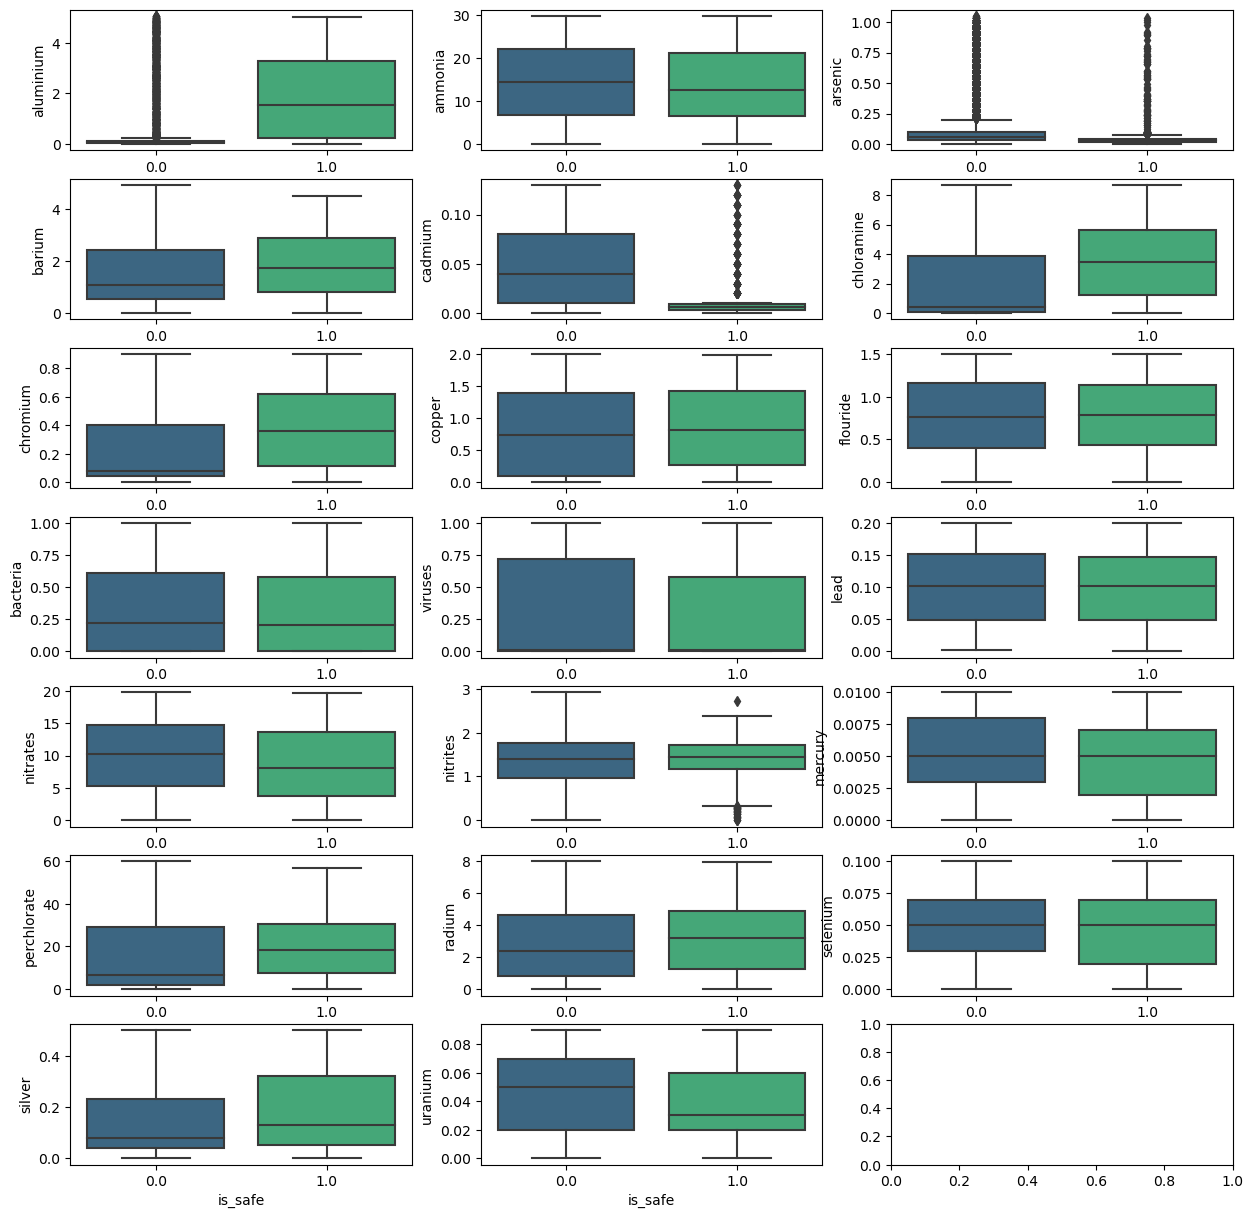

In [53]:
feat_names = df.select_dtypes(include='number').columns.tolist()
feat_names.remove('is_safe')

num_feats = len(feat_names)
width = 3
height = -(num_feats // -width)

fig, axes = plt.subplots(height, width, figsize=(15, 15))
ax = axes.flatten()

for i, col in enumerate(feat_names):
    sns.boxplot(x='is_safe', y=col, data=df, ax=ax[i], palette='viridis')

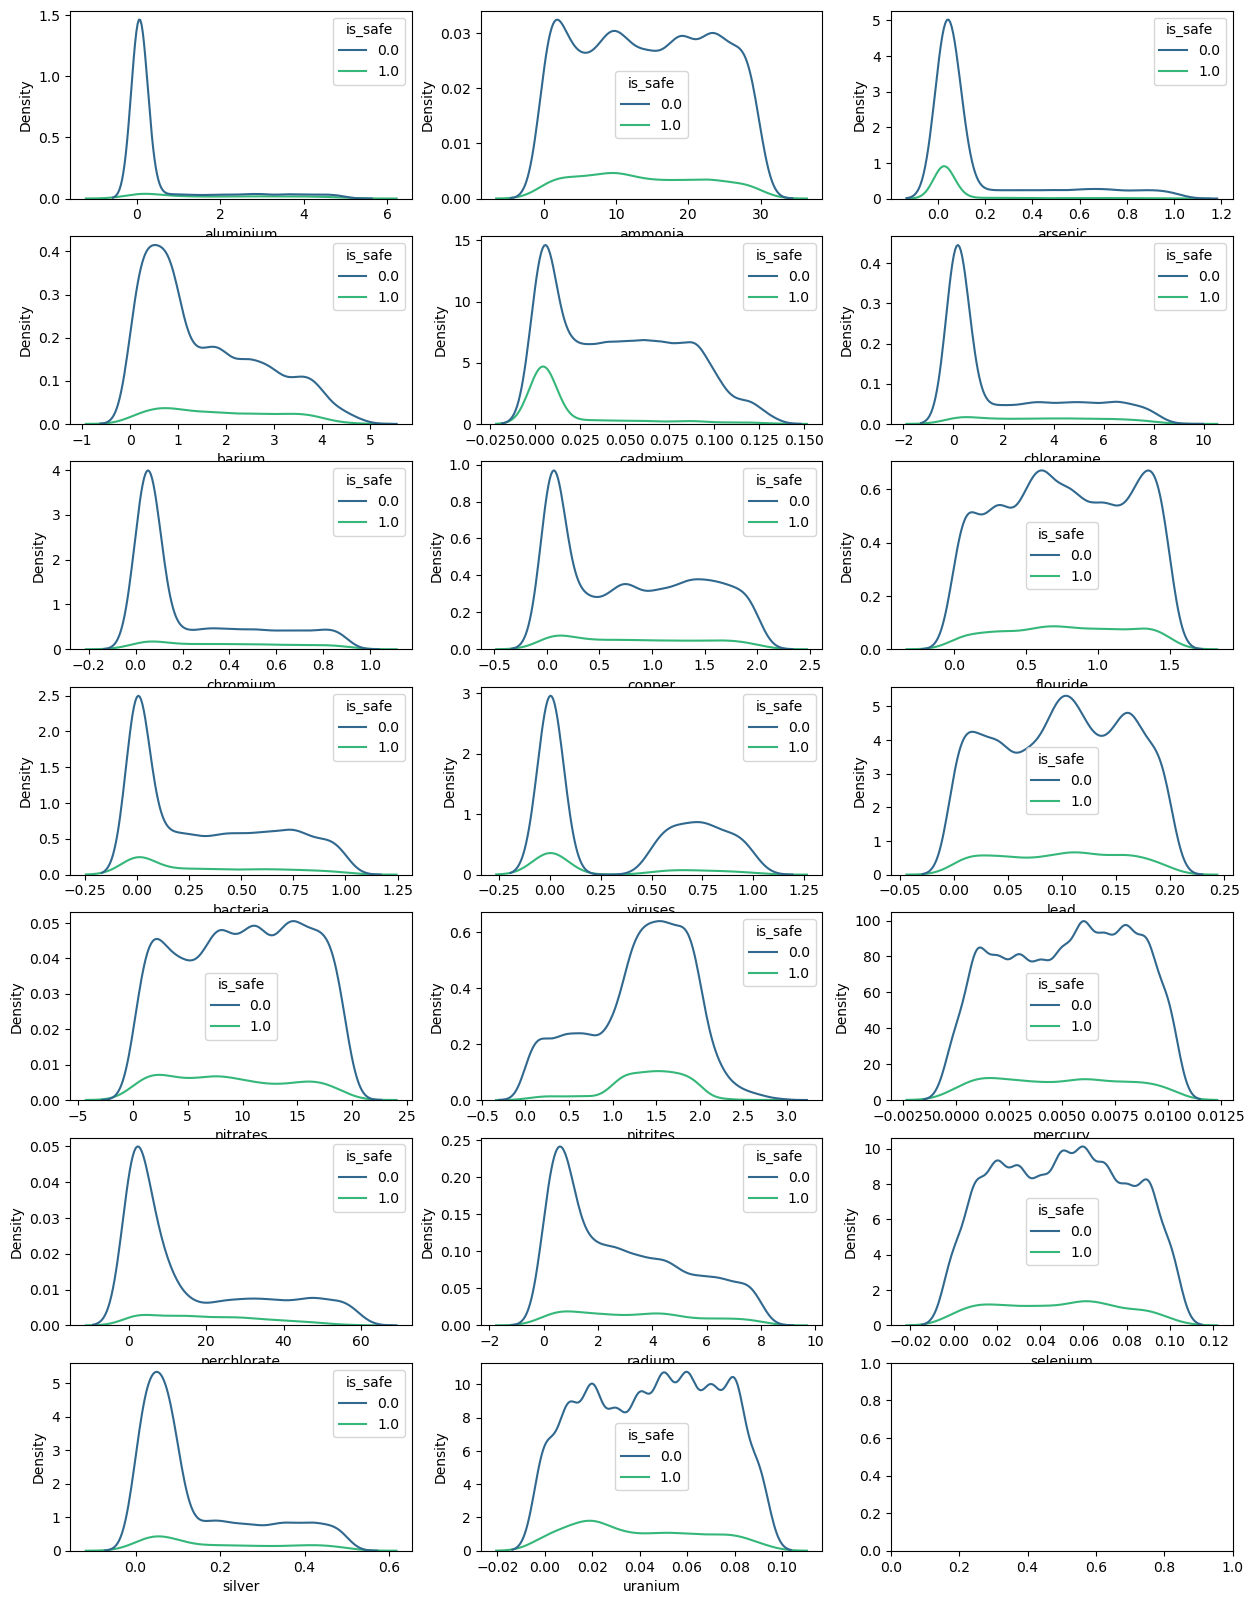

In [62]:
fig, axes = plt.subplots(height, width, figsize=(15, 20))
ax = axes.flatten()

for i, col in enumerate(feat_names):
    sns.kdeplot(x=col, data=df, ax=ax[i], hue=df['is_safe'], palette='viridis')

## Train-test Split

In [63]:
X = df.drop(columns='is_safe')
y = df['is_safe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6396, 20), (1600, 20), (6396,), (1600,))

In [68]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', PowerTransformer())
])

preprocessor = ColumnTransformer([
    ('numeric', num_pipe, feat_names)
])

# Define models
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'LGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42),
}

# Iterate over models
for name, model in models.items():
    pipe = Pipeline([
        ('pre', preprocessor),
        ('algo', model)
    ])
    
    print(f"Evaluating {name}...")
    # Train model
    pipe.fit(X_train, y_train)
    # Predict
    y_pred = pipe.predict(X_test)
    # Evaluate
    accuracy = f1_score(y_test, y_pred, average='macro')
    print(f"F1 macro: {accuracy:.4f}")

Evaluating Random Forest...
F1 macro: 0.8870
Evaluating Logistic Regression...
F1 macro: 0.7144
Evaluating LGBM...
F1 macro: 0.9311


In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1418
         1.0       0.87      0.89      0.88       182

    accuracy                           0.97      1600
   macro avg       0.93      0.94      0.93      1600
weighted avg       0.97      0.97      0.97      1600



In [72]:
print(confusion_matrix(y_test, y_pred))

[[1393   25]
 [  20  162]]
